In [5]:
import torch 
print(torch.__version__)

2.7.0+cpu


Wczytanie danych

In [8]:
import zipfile

zip_path = "archive(1).zip"
extract_to = "german-traffic-signs"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Wypakowano!")

Wypakowano!


In [9]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

In [10]:
transform = transforms.Compose([
   transforms.Resize((32, 32)), # Ujednolicenie rozmiarów obrazków
   transforms.ToTensor(), # Zamiana na tensor
   transforms.Normalize((0.5,), (0.5,)) # Standaryzacja
])

In [11]:
import os
base_path = "german-traffic-signs"
print(os.listdir(base_path))

['Meta', 'Meta.csv', 'Test', 'Test.csv', 'Train', 'Train.csv', 'Train_split.csv', 'Val_split.csv']


In [12]:
import torch
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
class GTSRBDataset(Dataset):
   def __init__(self, csv_file, root_dir, transform=None):
       self.annotations = pd.read_csv(csv_file)
       self.root_dir = root_dir
       self.transform = transform
   def __len__(self):
       return len(self.annotations)
   def __getitem__(self, idx):
       img_name = os.path.join(self.root_dir, self.annotations.iloc[idx]['Path'])
       image = Image.open(img_name)
       label = int(self.annotations.iloc[idx]['ClassId'])
       if self.transform:
           image = self.transform(image)
       return image, label

In [13]:
from torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
   transforms.Resize((32, 32)),
   transforms.ToTensor()
])
train_data = GTSRBDataset(
   csv_file='german-traffic-signs/Train.csv',
   root_dir='german-traffic-signs',
   transform=transform
)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [14]:
test_data = GTSRBDataset(
   csv_file='german-traffic-signs/Test.csv',
   root_dir='german-traffic-signs',
   transform=transform
)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [15]:
test_df = pd.read_csv('german-traffic-signs/Test.csv')
print(test_df.head())
print(test_df.shape)

   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png
(12630, 8)


In [16]:
from sklearn.model_selection import train_test_split

full_train_df = pd.read_csv('german-traffic-signs/Train.csv')  # Wczytujemy już istniejący zbiór treningowy
train_split, val_split = train_test_split( # Dzielimy zbiór treningowy na treningowy i walidacyjny
   full_train_df,
   test_size=0.2,
   stratify=full_train_df['ClassId'],
   random_state=42
)

train_split.to_csv('german-traffic-signs/Train_split.csv', index=False)
val_split.to_csv('german-traffic-signs/Val_split.csv', index=False)

In [17]:
train_data = GTSRBDataset(
    csv_file='german-traffic-signs/Train_split.csv',
    root_dir='german-traffic-signs',
    transform=transform
)

val_data = GTSRBDataset(
    csv_file='german-traffic-signs/Val_split.csv',
    root_dir='german-traffic-signs',
    transform=transform
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

Upewniamy się, że w naszej bazie danych znajdują się 43 etykiety

In [19]:
df = pd.read_csv("german-traffic-signs/Train.csv")
print("Min label:", df['ClassId'].min())
print("Max label:", df['ClassId'].max())
print("Unikalnych etykiet:", df['ClassId'].nunique())

Min label: 0
Max label: 42
Unikalnych etykiet: 43


Konstrukcja sieci CNN

In [17]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)) 
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [18]:
x = torch.ones((1, 3, 32, 32))
out = model(x)
print(out.shape)

torch.Size([1, 64, 8, 8])


In [19]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((1, 3, 32, 32))
model(x).shape

torch.Size([1, 4096])

In [20]:
model.add_module('fc1', nn.Linear(4096, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 43)) # 43 etykiety

In [21]:
device = torch.device("cpu")

model = model.to(device)

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
def train(model, num_epochs, train_loader, val_loader):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_loader.dataset)
        accuracy_hist_train[epoch] /= len(train_loader.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(val_loader.dataset)
        accuracy_hist_valid[epoch] /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [24]:
torch.manual_seed(1)

num_epochs = 10
hist = train(model, num_epochs, train_loader, val_loader)

Epoch 1 accuracy: 0.5970 val_accuracy: 0.9296
Epoch 2 accuracy: 0.9395 val_accuracy: 0.9782
Epoch 3 accuracy: 0.9737 val_accuracy: 0.9857
Epoch 4 accuracy: 0.9823 val_accuracy: 0.9894
Epoch 5 accuracy: 0.9871 val_accuracy: 0.9929
Epoch 6 accuracy: 0.9897 val_accuracy: 0.9934
Epoch 7 accuracy: 0.9916 val_accuracy: 0.9932
Epoch 8 accuracy: 0.9913 val_accuracy: 0.9941
Epoch 9 accuracy: 0.9931 val_accuracy: 0.9939
Epoch 10 accuracy: 0.9945 val_accuracy: 0.9953


Wykresy krzywych uczenia

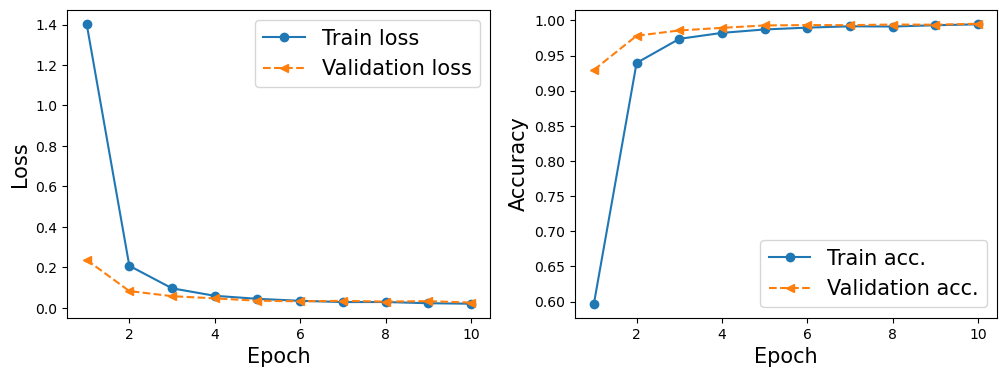

In [26]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

Sprawdzanie modelu na zbiorze testowym

In [28]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
   for x_batch, y_batch in test_loader:
       x_batch = x_batch.to(device).float()
       y_batch = y_batch.to(device)
       outputs = model(x_batch)
       predicted = torch.argmax(outputs, dim=1)
       correct += (predicted == y_batch).sum().item()
       total += y_batch.size(0)
accuracy = correct / total
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.9515


12 przykładów

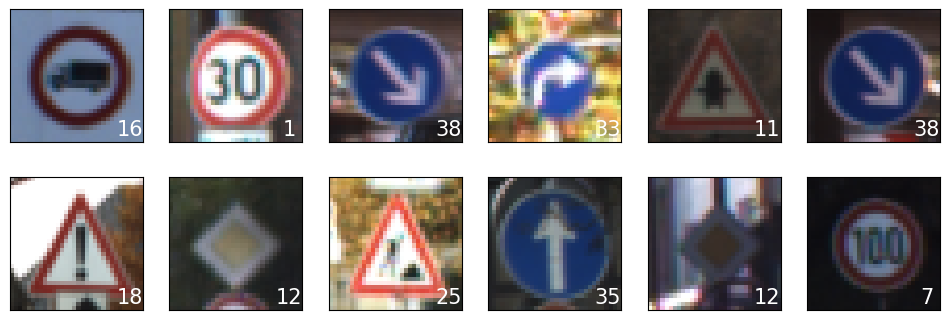

In [30]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
   ax = fig.add_subplot(2, 6, i+1)
   ax.set_xticks([]); ax.set_yticks([])
   img, label = test_data[i]
   x = img.unsqueeze(0).to(device).float()
   y_pred = torch.argmax(model(x))
   img_disp = img.permute(1, 2, 0).cpu().numpy()
   ax.imshow(img_disp)
   ax.text(0.9, 0.1, y_pred.item(),
           size=15, color='white',
           horizontalalignment='center',
           verticalalignment='center',
           transform=ax.transAxes)
plt.show()

In [31]:
# Zapisanie modelu do pliku:
if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/german-traffic-signs-cnn.ph'
torch.save(model, path)

Błędne klasyfikacje

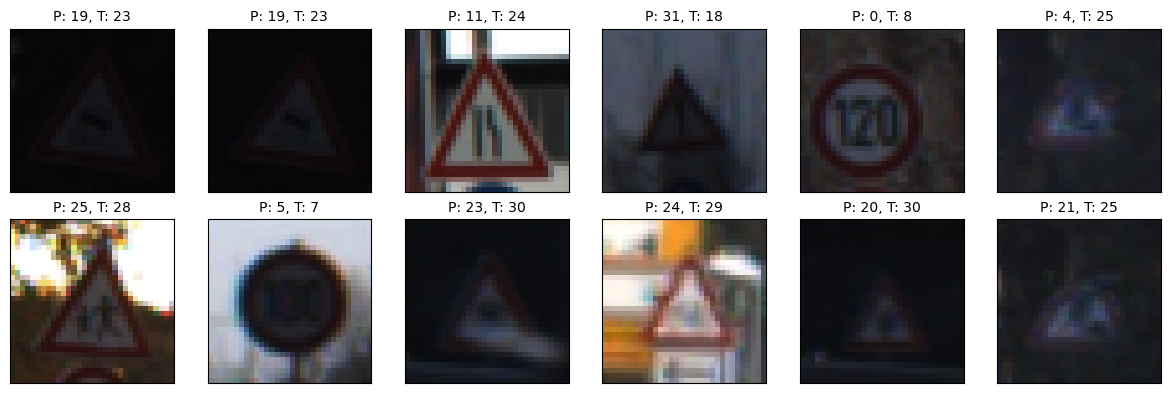

In [33]:
fig = plt.figure(figsize=(12, 4))
wrong = 0
for i in range(len(test_data)):
   img, true_label = test_data[i]
   x = img.unsqueeze(0).to(device).float()
   pred = model(x)
   predicted_label = torch.argmax(pred, dim=1).item()
   if predicted_label != true_label:
       ax = fig.add_subplot(2, 6, wrong + 1)
       img_disp = img.permute(1, 2, 0).cpu().numpy()
       ax.imshow(img_disp)
       ax.set_xticks([]); ax.set_yticks([])
       ax.set_title(f'P: {predicted_label}, T: {true_label}', fontsize=10)
       wrong += 1
       if wrong == 12:
           break
plt.tight_layout()
plt.show()

Inny lr=0.005 i uczenie przez 20 epok

In [42]:
import torch.nn as nn

model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)) 
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [44]:
x = torch.ones((1, 3, 32, 32))
out = model(x)
print(out.shape)

torch.Size([1, 64, 8, 8])


In [46]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((1, 3, 32, 32))
model(x).shape

torch.Size([1, 4096])

In [48]:
model.add_module('fc1', nn.Linear(4096, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 43))

In [50]:
device = torch.device("cpu")

model = model.to(device)

In [52]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [54]:
def train(model, num_epochs, train_loader, val_loader):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_loader.dataset)
        accuracy_hist_train[epoch] /= len(train_loader.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(val_loader.dataset)
        accuracy_hist_valid[epoch] /= len(val_loader.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [56]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model, num_epochs, train_loader, val_loader)

Epoch 1 accuracy: 0.5803 val_accuracy: 0.9031
Epoch 2 accuracy: 0.8931 val_accuracy: 0.9526
Epoch 3 accuracy: 0.9290 val_accuracy: 0.9616
Epoch 4 accuracy: 0.9384 val_accuracy: 0.9614
Epoch 5 accuracy: 0.9392 val_accuracy: 0.9603
Epoch 6 accuracy: 0.9446 val_accuracy: 0.9680
Epoch 7 accuracy: 0.9504 val_accuracy: 0.9662
Epoch 8 accuracy: 0.9522 val_accuracy: 0.9518
Epoch 9 accuracy: 0.9516 val_accuracy: 0.9773
Epoch 10 accuracy: 0.9519 val_accuracy: 0.9793
Epoch 11 accuracy: 0.9563 val_accuracy: 0.9774
Epoch 12 accuracy: 0.9563 val_accuracy: 0.9774
Epoch 13 accuracy: 0.9607 val_accuracy: 0.9749
Epoch 14 accuracy: 0.9569 val_accuracy: 0.9681
Epoch 15 accuracy: 0.9598 val_accuracy: 0.9674
Epoch 16 accuracy: 0.9564 val_accuracy: 0.9778
Epoch 17 accuracy: 0.9621 val_accuracy: 0.9746
Epoch 18 accuracy: 0.9643 val_accuracy: 0.9816
Epoch 19 accuracy: 0.9622 val_accuracy: 0.9774
Epoch 20 accuracy: 0.9634 val_accuracy: 0.9667


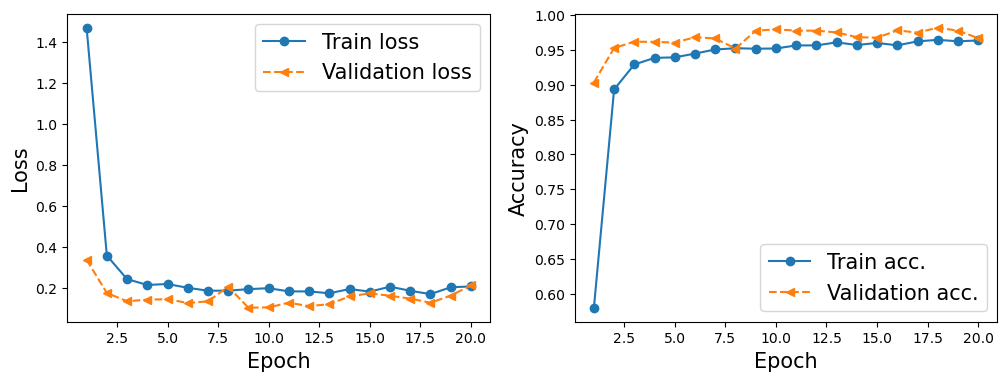

In [58]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

Sprawdzanie modelu na zbiorze testowym

In [61]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
   for x_batch, y_batch in test_loader:
       x_batch = x_batch.to(device).float()
       y_batch = y_batch.to(device)
       outputs = model(x_batch)
       predicted = torch.argmax(outputs, dim=1)
       correct += (predicted == y_batch).sum().item()
       total += y_batch.size(0)
accuracy = correct / total
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.8956


lr=0.005, 15 epok i pogłębiamy sieć

In [75]:
new_model = nn.Sequential()
new_model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1))
new_model.add_module('bn1', nn.BatchNorm2d(16))
new_model.add_module('relu1', nn.ReLU())

new_model.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1))
new_model.add_module('bn2', nn.BatchNorm2d(32))
new_model.add_module('relu2', nn.ReLU())
new_model.add_module('pool1', nn.MaxPool2d(kernel_size=2))  # 32x32 → 16x16

new_model.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
new_model.add_module('bn3', nn.BatchNorm2d(64))
new_model.add_module('relu3', nn.ReLU())

new_model.add_module('conv4', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
new_model.add_module('bn4', nn.BatchNorm2d(128))
new_model.add_module('relu4', nn.ReLU())
new_model.add_module('pool2', nn.MaxPool2d(kernel_size=2))  # 16x16 → 8x8

# Spłaszczamy tensor
new_model.add_module('flatten', nn.Flatten())  # 128 * 8 * 8 = 8192 cech
# Warstwy w pełni połączone
new_model.add_module('fc1', nn.Linear(8192, 512))
new_model.add_module('relu5', nn.ReLU())
new_model.add_module('dropout', nn.Dropout(p=0.5))
new_model.add_module('fc2', nn.Linear(512, 43))  # 43 klasy znaków

In [76]:
new_model = new_model.to(device)

In [77]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(new_model.parameters(), lr=0.005)

In [78]:
def train_model(model, train_loader, valid_loader, loss_fn, optimizer, device, epochs=10):
    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    model.train()
    for epoch in range(epochs):
        correct_train, total_train, total_loss = 0, 0, 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct_train += (y_pred.argmax(1) == y_batch).sum().item()
            total_train += y_batch.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(correct_train / total_train)

        model.eval()
        correct_valid, total_valid, valid_loss = 0, 0, 0

        with torch.no_grad():
            for x_val, y_val in valid_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                y_val_pred = model(x_val)
                loss = loss_fn(y_val_pred, y_val)
                valid_loss += loss.item()
                correct_valid += (y_val_pred.argmax(1) == y_val).sum().item()
                total_valid += y_val.size(0)

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accs.append(correct_valid / total_valid)
        model.train()

        print(f"Epoch {epoch+1}: train acc={train_accs[-1]:.4f}, val acc={valid_accs[-1]:.4f}")

    return train_losses, valid_losses, train_accs, valid_accs

In [79]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader_new = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader_new = DataLoader(val_data, batch_size=batch_size)

In [80]:
history = train_model(
    model=new_model,
    train_loader=train_loader_new,
    valid_loader=valid_loader_new,
    loss_fn=loss_fn,
    optimizer=optimizer,
    device=device,
    epochs=15
)

Epoch 1: train acc=0.1642, val acc=0.3282
Epoch 2: train acc=0.2579, val acc=0.3883
Epoch 3: train acc=0.2979, val acc=0.4412
Epoch 4: train acc=0.3293, val acc=0.5272
Epoch 5: train acc=0.3603, val acc=0.6273
Epoch 6: train acc=0.4428, val acc=0.7261
Epoch 7: train acc=0.5611, val acc=0.8856
Epoch 8: train acc=0.7116, val acc=0.9504
Epoch 9: train acc=0.8031, val acc=0.9791
Epoch 10: train acc=0.8545, val acc=0.9851
Epoch 11: train acc=0.8833, val acc=0.9922
Epoch 12: train acc=0.8971, val acc=0.9926
Epoch 13: train acc=0.9138, val acc=0.9932
Epoch 14: train acc=0.9279, val acc=0.9946
Epoch 15: train acc=0.9362, val acc=0.9946


In [87]:
correct = 0
total = 0
new_model.eval()
with torch.no_grad():
   for x_batch, y_batch in test_loader:
       x_batch = x_batch.to(device).float()
       y_batch = y_batch.to(device)
       outputs = new_model(x_batch)
       predicted = torch.argmax(outputs, dim=1)
       correct += (predicted == y_batch).sum().item()
       total += y_batch.size(0)
accuracy = correct / total
print(f"Test accuracy (new model): {accuracy:.4f}")

Test accuracy (new model): 0.9731


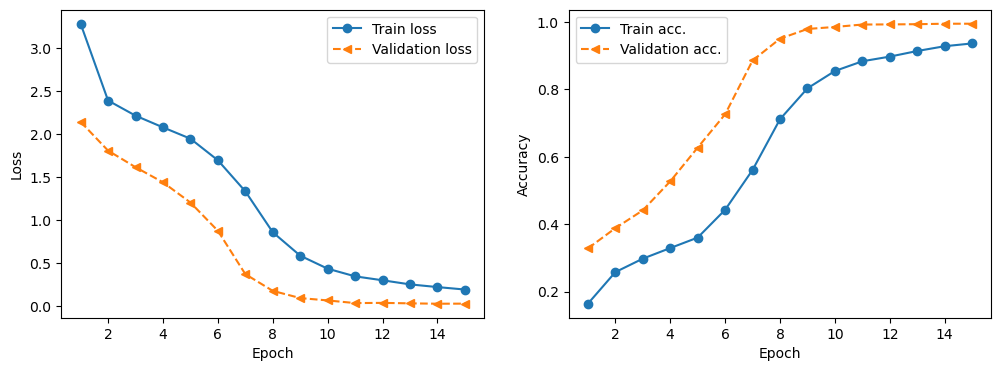

In [88]:
x_arr = np.arange(len(history[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, history[0], '-o', label='Train loss')
ax.plot(x_arr, history[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss'); ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, history[2], '-o', label='Train acc.')
ax.plot(x_arr, history[3], '--<', label='Validation acc.')
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy'); ax.legend()

plt.show()

Wersja z scheduler Exponential Decay, lr=0.001, 10 epok

In [33]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)) 
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [35]:
x = torch.ones((1, 3, 32, 32))
out = model(x)
print(out.shape)

torch.Size([1, 64, 8, 8])


In [37]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((1, 3, 32, 32))
model(x).shape

torch.Size([1, 4096])

In [39]:
model.add_module('fc1', nn.Linear(4096, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 43))

In [41]:
device = torch.device("cpu")

model = model.to(device)

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
from torch.optim.lr_scheduler import ExponentialLR
scheduler = ExponentialLR(optimizer, gamma=0.89)  # co epokę lr *= 0.89


In [49]:
def train(model, num_epochs, train_loader, val_loader, scheduler=scheduler):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_loader.dataset)
        accuracy_hist_train[epoch] /= len(train_loader.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()


        loss_hist_valid[epoch] /= len(val_loader.dataset)
        accuracy_hist_valid[epoch] /= len(val_loader.dataset)

        if scheduler is not None:
            scheduler.step()
               
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [51]:
torch.manual_seed(1)

num_epochs = 10
hist = train(model, num_epochs, train_loader, val_loader)

Epoch 1 accuracy: 0.6608 val_accuracy: 0.9549
Epoch 2 accuracy: 0.9562 val_accuracy: 0.9869
Epoch 3 accuracy: 0.9818 val_accuracy: 0.9885
Epoch 4 accuracy: 0.9886 val_accuracy: 0.9929
Epoch 5 accuracy: 0.9943 val_accuracy: 0.9922
Epoch 6 accuracy: 0.9954 val_accuracy: 0.9949
Epoch 7 accuracy: 0.9963 val_accuracy: 0.9944
Epoch 8 accuracy: 0.9971 val_accuracy: 0.9954
Epoch 9 accuracy: 0.9982 val_accuracy: 0.9944
Epoch 10 accuracy: 0.9989 val_accuracy: 0.9952


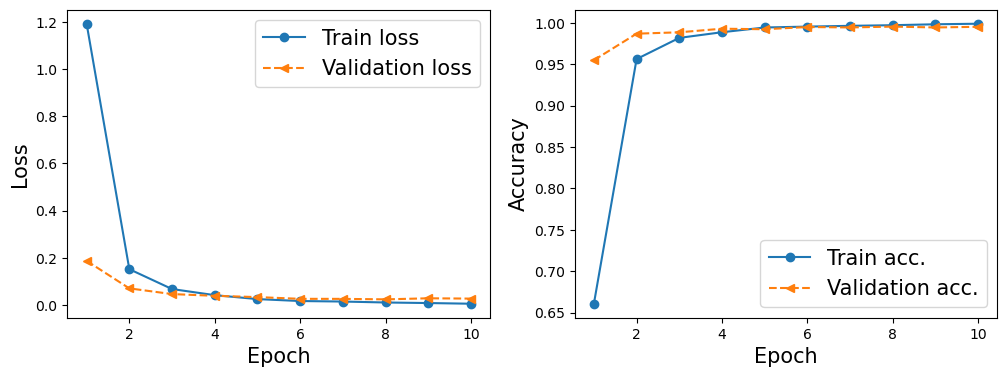

In [53]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [55]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
   for x_batch, y_batch in test_loader:
       x_batch = x_batch.to(device).float()
       y_batch = y_batch.to(device)
       outputs = model(x_batch)
       predicted = torch.argmax(outputs, dim=1)
       correct += (predicted == y_batch).sum().item()
       total += y_batch.size(0)
accuracy = correct / total
print(f'Test accuracy: {accuracy:.4f}')

Test accuracy: 0.9522
